In [1]:
import numpy as np
import scipy
from tqdm.notebook import tqdm
import scipy.io

In [2]:
from mylib import parser
from dtaidistance import dtw, dtw_ndim
from mylib import frechet

In [3]:
from mylib import data_generator

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
font =  {
            'family': 'DejaVu Sans',
            'weight': 'normal',
            'size'  :  14
        }

matplotlib.rc('font', **font)
%config InlineBackend.figure_formats = ['svg']

# Синтетические данные

In [5]:
def plot_stroke(stroke, ax, c='b'):
    points = stroke['points']
    for i in range(len(points) - 1):
        ax.plot([points[i][0], points[i + 1][0]], [points[i][1], points[i + 1][1]], c=c)
    if stroke['type'] == "Ring":
        last = len(points) - 1
        ax.plot([points[0][0], points[last][0]], [points[0][1], points[last][1]], c=c)
    ax.axis('off')

In [6]:
data = data_generator.generate_data(300, size=1)
data_generator.write_data(data)

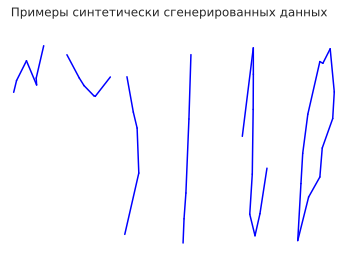

In [7]:
n_classes = 6
fig, axes = plt.subplots(ncols=n_classes, sharey=True, sharex=True)
for i in range(n_classes):
    plot_stroke(data[0][i], axes[i])
fig.suptitle("Примеры синтетически сгенерированных данных")
plt.savefig("../figures/syntetic_data.svg")
plt.show()

# DTW

In [8]:
preprocessed_for_dtw = parser.parse_data("../data/syntetic.txt", 4)
len(preprocessed_for_dtw[0])

1800

In [9]:
def pairwise_dtw(data, ndim=False):
    matrix = np.zeros(shape=(len(data), len(data)))
    for i in tqdm(range(len(data))):
        for j in range(i, len(data)):
            if ndim:
                matrix[i][j] = dtw_ndim.distance_fast(np.array(data[i][1:]), np.array(data[j][1:]))
            else:
                matrix[i][j] = dtw.distance_fast(data[i], data[j])
    return matrix + matrix.T

In [10]:
%%time
dtw_ndim_distance_matrix = pairwise_dtw(preprocessed_for_dtw[1], ndim=True)

In [13]:
%%time
dtw_distance_matrix = pairwise_dtw(preprocessed_for_dtw[0], ndim=False)
scipy.io.savemat("dtw_distance.mat", {"matrix": dtw_distance_matrix})

# Frechet

In [15]:
strokes_for_frechet = frechet.txt2streaks('../data/syntetic.txt')
len(strokes_for_frechet)

1800

In [16]:
%%time
frechet_distance_matrix = frechet.Matrix_pairwise_distances(strokes_for_frechet, strokes_for_frechet)

# KNN

In [19]:
class DistanceFromMatrix:
    
    def __init__(self, matrix):
        self.__matrix = matrix
    
    def __call__(self, i, j):
        return self.__matrix[int(i[0])][int(j[0])]

In [20]:
X = np.arange(len(preprocessed_for_dtw[0]), dtype=int).reshape(-1, 1)
y = data[1]

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [23]:
n_neighbors_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [25]:
def validate_distance(X, y, weights, distance_matrix, n_neighbors_list):
    result = []
    for n in n_neighbors_list:
        model = KNeighborsClassifier(metric=DistanceFromMatrix(distance_matrix),
                                 algorithm='brute', n_neighbors=n, weights=weights)
        result.append(cross_val_score(model, X, y, scoring='accuracy').mean())
    return result

In [27]:
%%time
dtw_ndim_uniform = validate_distance(X, y, "uniform", dtw_ndim_distance_matrix, n_neighbors_list)
dtw_ndim_distance = validate_distance(X, y, "distance", dtw_ndim_distance_matrix, n_neighbors_list)
dtw_uniform = validate_distance(X, y, "uniform", dtw_distance_matrix, n_neighbors_list)
dtw_distance = validate_distance(X, y, "distance", dtw_distance_matrix, n_neighbors_list)
frechet_uniform = validate_distance(X, y, "uniform", frechet_distance_matrix, n_neighbors_list)
frechet_distance = validate_distance(X, y, "distance", frechet_distance_matrix, n_neighbors_list)

CPU times: user 4min 7s, sys: 628 ms, total: 4min 8s
Wall time: 4min 8s


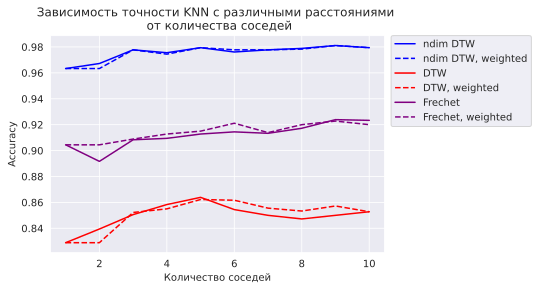

In [33]:
plt.plot(n_neighbors_list, dtw_ndim_uniform, c='b', label="ndim DTW")
plt.plot(n_neighbors_list, dtw_ndim_distance, c='b', label="ndim DTW, weighted", linestyle='dashed')
plt.plot(n_neighbors_list, dtw_uniform, c='r', label="DTW")
plt.plot(n_neighbors_list, dtw_distance, c='r', label="DTW, weighted", linestyle='dashed')
plt.plot(n_neighbors_list, frechet_uniform, c='purple', label="Frechet")
plt.plot(n_neighbors_list, frechet_distance, c='purple', label="Frechet, weighted", linestyle='dashed')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Количество соседей")
plt.ylabel("Accuracy")
plt.title("Зависимость точности KNN с различными расстояниями \n от количества соседей")
plt.savefig("img/preliminary_experiment.svg", bbox_inches='tight')
plt.show()